<span style="font-family:Papyrus; font-size:3em;">Homework 2</span>

<span style="font-family:Papyrus; font-size:2em;">Cross Validation</span>

# Problem

In this homework, you will analyze the effect on the quality of the model fit and parameter estimates
as a result of the number of parameters and the noise in the observational data.
For a two parameter model, use $S_1 \xrightarrow{v_1} S_2 \xrightarrow{v_3} S_3$,
where $v_i = k_i s_i$, $k_i$ is a parameter to estimate, and $s_i$ is the concentration of $S_i$.
The initial concentration of $S_1 = 10$, and the true value of $k_i$ is $i$.
You will design experiments, implement codes to run them, run the experiments, and interpret the results.
You will produce two tables structure as the one below, one with $R^2$ values for the factor levels
and the other with the average parameter std.

 |        | std = 0.5 | std=1.0 | std=1.5
 ------   | --------- | ------- | -------
 numParameter=2 | ? | ? | ?
 numParameter=4 | ? | ? | ?
 numParameter=6 | ? | ? | ?
 

1. Write the 3 models in Antimony, and produce plots for their true values. Use a simulation time
of 10 and 100 points.
1. Write a function that creates synthetic data given the parameters std and numParameter.
1. Extend the ``CrossValidator`` class in ``common/util_crossvalidation.py`` by adding the method
``calcAvgParameterStd``. You will do this by creating a new class, ``ExtendedCrossValidator`` that
subclasses ``CrossValidator`` and has the method ``calcAvgParameterStd``. Be sure to include
a test for the new method. **DO NOT COPY CODES FROM COMMON.**
1. Run experiments that produce the tables described above.
1. Using the baseline std=1.0, numParameter=4, calculate $\mu$, $\alpha_{i,k_i}$,
$\gamma_{i,i_k,j,k_j}$.
1. Answer the following questions
   1. Are there any significant interaction effects?
   1. What is the general effect on $R^2$ and average parameter std as the number of parameters increases?
   1. What does the noise standard deviation influence quality, especially as the number of parameters increases?

# Programming Preliminaries
This section provides the setup to run your python codes.

In [1]:
IS_COLAB = False
#
if IS_COLAB:
  !pip install tellurium
  !pip install SBstoat
#    
# Constants for standalone notebook
if not IS_COLAB:
    CODE_DIR = "/home/ubuntu/advancing-biomedical-models/common"
else:
    from google.colab import drive
    drive.mount('/content/drive')
    CODE_DIR = "/content/drive/My Drive/Winter 2021/common"
import sys
sys.path.insert(0, CODE_DIR)

In [2]:
import util_crossvalidation as ucv
from SBstoat.namedTimeseries import NamedTimeseries, TIME

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tellurium as te

In [3]:
END_TIME = 5
NUM_POINT = 100
NOISE_STD = 0.5

# Generate Models

In [4]:
MODEL = """
S1 -> S2; k1*S1
S2 -> S3; k2*S2

S1 = 10
S2 = 0
k1 = 1
k2 = 2
"""
rr = te.loada(MODEL)

In [5]:
class Model(object):
    
    def __init__(self, numParameter, s1Value=10):
        """
        numParameter: int
            number of parameters in the model
        s1Value: float
            Initial value for S1
        """
        self.numParameter = numParameter
        self.s1Value = s1Value
        #
        # modelStr - Antimony model
        # parameterDct - true values of parameters
        self.modelStr, self.parameterDct = self._generateModel()
        self.parameterNames = list(self.parameterDct.keys())
        # Calculated by other methods
        self.resultTS = None  # Simulation result
        
    def _generateModel(self):
        """
        Constructs an antimony model.
        
        Returns
        -------
        str: antimony model
        list-str: model parameters
        dict:
            key: parameterName
            value: true value
        """
        reactionStr = ""
        initializationStr = ""
        parameterDct = {}
        for idx in range(1, self.numParameter+1):
            if idx == 1:
                value = self.s1Value
            else:
                value = 0
            parameterName = "k%d" % idx
            parameterDct[parameterName] = idx
            initializationStr += "\nS%d = %2.2f" % (idx, value)
            initializationStr += "\n%s = %2.2f" % (parameterName, 1.0*idx)
            reactionStr += "\nS%d -> S%d; k%d*S%d" % (idx, idx+1, idx, idx)
        modelStr = "%s\n%s" % (reactionStr, initializationStr)
        return modelStr, parameterDct
    
    def simulate(self, endTime=END_TIME, numPoint=NUM_POINT):
        """
        Simulates the model.
        
        Parameters
        ----------
        endTime: float
            end of the simulation
        numPoint: int
            number of points in the simulation
        """
        rr = te.loada(self.modelStr)
        arr = rr.simulate(0, endTime, numPoint)
        self.resultTS = NamedTimeseries(namedArray=arr)
    
    def plotResult(self, **kwargs):
        """
        Plots the result of a simulation.
        
        Parameters
        ----------
        kwargs: dict
            arguments passed to plot
        """
        if self.resultTS is None:
            self.simulate()
        ucv.plotTS(self.resultTS, linetype="line", **kwargs)

# Tests
numParameter = 3
model = Model(numParameter)
_ = te.loada(model.modelStr)
assert(len(model.parameterDct) == numParameter)
# All species and constants are present
for term in ["S", "k"]:
    trues = ["%s%d" % (term, n) in model.modelStr for n in range(1, numParameter+1)]            
    assert(all(trues))
#   simulate
model.simulate()
assert(len(model.resultTS) > 0)
#   plotResult
model.plotResult(title="test", isPlot=False)

<Figure size 432x288 with 0 Axes>

# Generate Synthetic Data

In [6]:
class SyntheticModel(Model):
    """Extends Model by providing generated observations."""
    
    def __init__(self, *args, **kwargs):
        """
        numParameter: int
            number of parameters in the model
        """
        super().__init__(*args, **kwargs)
        self.observedTS = None
    
    def generateObserved(self, noiseStd=NOISE_STD, **kwargs):
        """
        Creates synthetic data for the model.

        model: Model
        noiseStd: float
        kwargs: dict
            optional keywords passed to run model
        """
        self.simulate(**kwargs)
        self.observedTS = ucv.makeSyntheticData(fittedTS=model.resultTS, std=noiseStd)

# Tests
model = SyntheticModel(3)
model.generateObserved()
assert(len(model.observedTS) == len(model.observedTS))

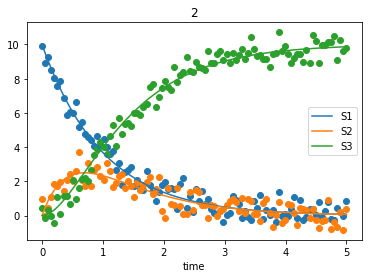

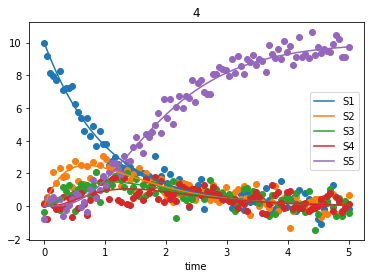

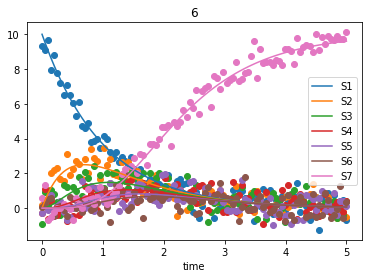

In [7]:
# Here are some examples of the data
for numParameter in [2, 4, 6]:
    model = SyntheticModel(numParameter)
    model.generateObserved()
    ax = ucv.plotTS(model.resultTS, linetype="line")
    _ = ucv.plotTS(model.observedTS, ax=ax, title="%d" % numParameter)

# ``ExtendedFitter``

In [23]:
class ExtendedCrossValidator(ucv.CrossValidator):
    """Calculates the average standard deviation of parameter estimates."""
    
    def calcAverageParameterStd(self):
        stdDct = {n: [] for n in self.parameterNames}
        for parameters in self.parametersCol:
            valuesDct = parameters.valuesdict()
            [stdDct[n].append(valuesDct[n]) for n in self.parameterNames]
        # Stds of the parameters
        stds = [np.std(stdDct[n]) for n in self.parameterNames]
        return np.mean(stds)
    
# Tests
numFold = 5
numParameter = 4
model = SyntheticModel(numParameter)
model.generateObserved(noiseStd=0.1)
validator = ExtendedCrossValidator(numFold, model.modelStr, model.observedTS, model.parameterNames,
    trueParameterDct=model.parameterDct)
validator.execute()
validator.calcAverageParameterStd()

0.04224255910584432

In [24]:
validator.reportParameters()

,fold,true,predicted,parameter
0,0,1,0.810981,k1
1,0,2,0.921528,k2
2,0,3,0.921528,k3
3,0,4,0.921521,k4
4,1,1,0.949961,k1
5,1,2,0.999969,k2
6,1,3,1.000000,k3
7,1,4,1.000000,k4
8,2,1,0.884237,k1
9,2,2,1.000000,k2
